planowane zmienne:
numer ogloszenia git
status (obsadzono/nie/anulowano itd) git
wynagrodzenie - kwota/null git 
miejsce pracy git
nazwa stanowiska
czy zdalna (regex)
wyksztalcenie (regex)
rodzaj umowy (uop/zastepstwo)
wymagane doswiadczenie
prawo jazdy
liczba stanowisk
wymar etatu

In [3]:
import pandas as pd
import numpy as np
import re
# FOR APPLYING SELENIUM:
import selenium # Python Selenium
from selenium import webdriver # for specifying webdriver
import requests
from bs4 import BeautifulSoup

import time 

from webdriver_manager.microsoft import EdgeChromiumDriverManager # msedgedriver for automatized access to Microsoft Edge
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service # needed since Selenium 4.10.0 see: https://github.com/SeleniumHQ/selenium/commit/9f5801c82fb3be3d5850707c46c3f8176e3ccd8e
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# FOR SAVING DATA:
import pickle # pickle format of saved output

# function defined for saving Python objects
def save_object(obj, filename): # function for saving output
    with open(filename, 'wb') as output:  # overwrites any existing file
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [2]:
chromepath = ChromeDriverManager().install()
print(chromepath)

C:\Users\mateu\.wdm\drivers\chromedriver\win64\123.0.6312.122\chromedriver-win32/chromedriver.exe


In [28]:
website = "https://nabory.kprm.gov.pl/zachodniopomorskie/bialogard/inspektor,131913,v7"
service_chrome = Service(executable_path = chromepath) 
options_chrome = webdriver.ChromeOptions()
driver_chrome = webdriver.Chrome(service = service_chrome, options = options_chrome)

driver_chrome.maximize_window() 
driver_chrome.get(website) 
driver_chrome.execute_script("window.scrollTo(0, document.body.scrollHeight);")
 
#closing cookies
close_button = WebDriverWait(driver_chrome, 10).until(EC.element_to_be_clickable((By.ID, 'cookies-close')))
close_button.click()

data=[]
i=0
for i in range (2500):
    source_code_main_page = driver_chrome.page_source
    soup1 = BeautifulSoup(source_code_main_page, 'html.parser')

#Job posting number     
    job_posting_number_element = soup1.find('span', class_='adv-number')
    if job_posting_number_element:
        job_posting_number = job_posting_number_element.text.strip()
        
    else:
        job_posting_number = "Not found"
#Wage with lambda expression
    extract_numeric_wage = lambda wage: re.sub('[^0-9,]', '', wage)
    wage_element = soup1.find('div', class_='info-circle__content info-circle__content--salary info-circle__content--small-text')
    if wage_element:
        wage = extract_numeric_wage(wage_element.text.strip())
    else:
        wage = "Not found"
#Name of the job 
    job_title_element = soup1.find('h1', class_='job-post__main-content__job-information__important-information__job-title__institution-title')
    if job_title_element:
        job_title = job_title_element.text.strip()
    else:
        job_title = "Not found"        
#Number of positions       
    positions_element = soup1.find('div', class_='info-circle__content info-circle__content--work-time-cnt')
    if positions_element:
        positions = positions_element.text.strip()
    else:
        positions = "Not found"
#Is it full time/part time?
    full_time_element = soup1.find('div', class_='info-circle__content info-circle__content--work-time')
    if full_time_element:
        full_time = full_time_element.text.strip()
    else:
        full_time = "Not found"
    #Start/end date
    posting_end_date = soup1.find('div', class_='application__content__container__right-column__warnings')
    if posting_end_date:
        pattern_date = r'\b\d{2}\.\d{2}\.\d{4}\b'
        date_end_match = re.findall(pattern_date, posting_end_date.get_text())
        if date_end_match:
            date_end = date_end_match[0].strip()
        else:
            date_end = "Not found"
    else:
        date_end = "Not found"
    
    posting_start_date = soup1.find('div', class_='job-post__header__bottom-row__more-information__adv-number')
    if posting_start_date:
        pattern_date = r'\b\d{2}\.\d{2}\.\d{4}\b'
        date_start_match = re.findall(pattern_date, posting_start_date.get_text())
        if date_start_match:
            date_start = date_start_match[0].strip()
        else:
            date_start = "Not found"
    else:
        date_start = "Not found"
    
#Is it hybrid?
    try:
        element_remote = driver_chrome.find_element(By.XPATH, "//li[contains(text(),'zdaln')]")
        remote = element_remote.text
    except:
        remote = "Not found"    
#Requirements div finding
    requirements_div = soup1.find('div', class_='job-post__main-content__requirements__list')
#Experience needed?
    if requirements_div:
        first_list = requirements_div.find('ul')
        list_items = first_list.find_all('li')
        for item in list_items:
            if 'Doświadczenie' in item.text:
                experience = item.text.strip()
                break
            else:
                experience = "Not found"
        for item in list_items:
            if 'Wykształcenie' in item.text:
                education = item.text.strip()
                break
            else:
                education = "Not found"
        for item in list_items:
            if 'angiel' in item.text:
                english = item.text.strip()
                break
            else:
                english = "Not found"   
        for item in list_items:
            if 'prawo jazdy' in item.text:
                driving = item.text.strip()
                break
            else:
                driving = "Not found"     
    else:
        print("No requirements div found.")      
#status 

    #getting to the page with the info o zakonczeniu naboru and getting source code
    try:
        link = driver_chrome.find_element(By.LINK_TEXT, 'TUTAJ')
        link.click()
        current_url = driver_chrome.current_url
    #USING REQUESTS  to find end result
        source_code_end_result = requests.get(current_url).text
        soup2 = BeautifulSoup(source_code_end_result, 'html.parser')
        end_result_element = soup2.find('div', class_='job-res').find_all('div', class_='col-xs-12')[1].get_text(strip=True)

        if end_result_element:
            end_result = end_result_element
        else:
            job_posting_number = "Not found"
    #City 
        city_element = soup2.find('div', class_='col-md-7')
        text = city_element.get_text()
        pattern = r'\b\d{2}-\d{3}\s+(.*)$'
        match = re.search(pattern, text)
        if match:
            city = match.group(1).strip()
        else:
            city = "Not found"  
        #getting to the previous (main) page
        driver_chrome.back()
    except:
        city = "Not found"
        job_posting_number="Not found"
        end_result="Not found"

    #getting to the next job posting
    if job_posting_number == "129407":
        driver_chrome.get("https://nabory.kprm.gov.pl/dolnoslaskie/wroclaw/starszy-referent,129405,v7")
        data.append({'Job Posting Number': job_posting_number, 'End Result': end_result, 'City': city, 'Wage': wage, 'Job title': job_title, 
                      'Number of positions': positions, 'full-time':full_time, 'education':education, 'Experience': experience, 
                      'If driving license': driving,'If english': english, 'Is hybrid': remote, 'Start date':date_start, 'End date':date_end})   
    else:
        content = driver_chrome.find_element(By.XPATH, "//a[contains(text(),'Poprzednie ogłoszenie')]")
        content.click()
        data.append({'Job Posting Number': job_posting_number, 'End Result': end_result, 'City': city, 'Wage': wage, 'Job title': job_title, 
                      'Number of positions': positions, 'full-time':full_time, 'education':education, 'Experience': experience, 
                      'If driving license': driving,'If english': english, 'Is hybrid': remote, 'Start date':date_start, 'End date':date_end})  
    i = i+1

df = pd.DataFrame(data)
print(df)
driver_chrome.quit()


     Job Posting Number                                         End Result  \
0                131913   nabór zakończony bez wyboru kandydatki/kandydata   
1                131912  nabór zakończony wyborem kandydatki/kandydataA...   
2                131910   nabór zakończony bez wyboru kandydatki/kandydata   
3                131909  nabór zakończony wyborem kandydatki/kandydataM...   
4                131908  nabór zakończony wyborem kandydatki/kandydataE...   
...                 ...                                                ...   
2495             129350  nabór zakończony wyborem kandydatki/kandydataN...   
2496             129349   nabór zakończony bez wyboru kandydatki/kandydata   
2497             129348   nabór zakończony bez wyboru kandydatki/kandydata   
2498             129347  nabór zakończony wyborem kandydatki/kandydataJ...   
2499          Not found                                          Not found   

           City       Wage            Job title Number of posit

In [32]:
df.to_csv("job_offers.csv", sep=";")

In [4]:
df1 = pd.read_csv("job_offers.csv", sep=';')

In [6]:
df1.head()

,Unnamed: 0,Job Posting Number,End Result,City,Wage,Job title,Number of positions,full-time,education,Experience,If driving license,If english,Is hybrid,Start date,End date
0,0,131913,nabór zakończony bez wyboru kandydatki/kandydata,Koszalin,"4242,00",inspektor,1,1,Wykształcenie: średnie ...,Not found,Posiadanie prawo jazdy kat. B,Not found,Not found,23.12.2023,28.12.2023
1,1,131912,nabór zakończony wyborem kandydatki/kandydataA...,Warszawa,Not found,starszy specjalista,1,1,Wykształcenie: wyższe,Doświadczenie zawodowe co najmniej 2 lata w o...,Not found,Not found,Częściowe wykonywanie pracy poza siedzibą urzę...,04.01.2024,15.01.2024
2,2,131910,nabór zakończony bez wyboru kandydatki/kandydata,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,Not found,częściowe wykonywanie pracy poza siedzibą urzę...,23.12.2023,09.01.2024
3,3,131909,nabór zakończony wyborem kandydatki/kandydataM...,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,Not found,częściowe wykonywanie pracy poza siedzibą urzę...,23.12.2023,09.01.2024
4,4,131908,nabór zakończony wyborem kandydatki/kandydataE...,Warszawa,Not found,inspektor,1,1,Wykształcenie: średnie,Doświadczenie zawodowe 1 rok doświadczenia z...,Not found,Not found,Not found,28.12.2023,12.01.2024


In [7]:
df_clean = df1
df_clean = df_clean.drop("Unnamed: 0", axis = 1)
print(df_clean.head())

  Job Posting Number                                         End Result  \
0             131913   nabór zakończony bez wyboru kandydatki/kandydata   
1             131912  nabór zakończony wyborem kandydatki/kandydataA...   
2             131910   nabór zakończony bez wyboru kandydatki/kandydata   
3             131909  nabór zakończony wyborem kandydatki/kandydataM...   
4             131908  nabór zakończony wyborem kandydatki/kandydataE...   

       City       Wage            Job title  Number of positions full-time  \
0  Koszalin    4242,00            inspektor                    1         1   
1  Warszawa  Not found  starszy specjalista                    1         1   
2  Warszawa  Not found             aplikant                    1         1   
3  Warszawa  Not found             aplikant                    1         1   
4  Warszawa  Not found            inspektor                    1         1   

                                           education  \
0  Wykształcenie: średni

In [8]:
df_clean.dtypes

Job Posting Number     object
End Result             object
City                   object
Wage                   object
Job title              object
Number of positions     int64
full-time              object
education              object
Experience             object
If driving license     object
If english             object
Is hybrid              object
Start date             object
End date               object
dtype: object

In [9]:
df_clean["End Result"].unique()

array(['nabór zakończony bez wyboru kandydatki/kandydata',
       'nabór zakończony wyborem kandydatki/kandydataAneta Stolarska\xa0\xa0\xa0\xa0Lublin',
       'nabór zakończony wyborem kandydatki/kandydataMateusz Szczepan\xa0\xa0\xa0\xa0Kraków',
       ...,
       'nabór zakończony wyborem kandydatki/kandydataVanessa Otawa-Białoskórska\xa0\xa0\xa0\xa0Świerklaniec',
       'nabór zakończony wyborem kandydatki/kandydataNatalia MIŁOSEK\xa0\xa0\xa0\xa0Katowice',
       'nabór zakończony wyborem kandydatki/kandydataJakub KUŹNICKI \xa0\xa0\xa0\xa0Gliwice'],
      dtype=object)

In [10]:
for column in df_clean.columns:
    df_clean[column] = df_clean[column].astype(str)

Data manipulation - adding a column with code instead of strings

In [11]:
def clean_data(value):
    if "anulowano" in value:
        return "Cancelled"
    elif "bez" in value:
        return "Candidate not found"
    elif "found" in value:
        return "End result not posted"
    else:
        return "Candidate found"

# Apply the function to the column
df_clean['clean_result'] = df_clean['End Result'].apply(clean_data)

In [12]:
df_clean.head(2)

,Job Posting Number,End Result,City,Wage,Job title,Number of positions,full-time,education,Experience,If driving license,If english,Is hybrid,Start date,End date,clean_result
0,131913,nabór zakończony bez wyboru kandydatki/kandydata,Koszalin,"4242,00",inspektor,1,1,Wykształcenie: średnie ...,Not found,Posiadanie prawo jazdy kat. B,Not found,Not found,23.12.2023,28.12.2023,Candidate not found
1,131912,nabór zakończony wyborem kandydatki/kandydataA...,Warszawa,Not found,starszy specjalista,1,1,Wykształcenie: wyższe,Doświadczenie zawodowe co najmniej 2 lata w o...,Not found,Not found,Częściowe wykonywanie pracy poza siedzibą urzę...,04.01.2024,15.01.2024,Candidate found


In [13]:
df_clean['clean_result'].unique()

array(['Candidate not found', 'Candidate found', 'Cancelled',
       'End result not posted'], dtype=object)

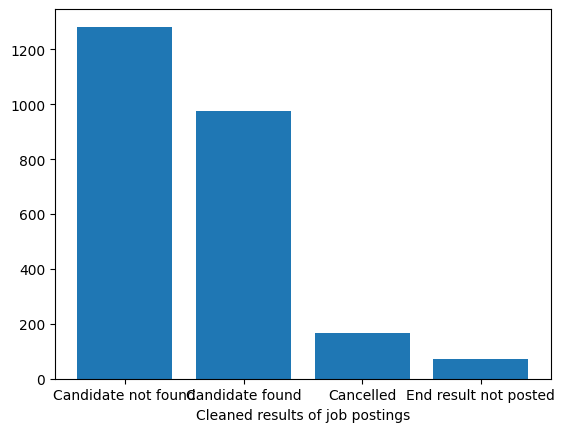

In [14]:
import matplotlib.pyplot as plt
result = df_clean['clean_result'].unique()
value_counts = df_clean['clean_result'].value_counts()
x=[]
plt.bar(result, value_counts.values)
plt.xlabel("Cleaned results of job postings")
column_titles = {
    0: "Cancelled",
    1: "No candidate found",
    2: "No result",
    3: "Candidate found"
}
plt.show()

In [15]:
df_clean_filtered = df_clean[(df_clean['clean_result'] != "Cancelled") & (df_clean['clean_result'] != "End result not posted")]

# Reset index after dropping rows
df_clean_filtered.reset_index(drop=True, inplace=True)

In [16]:
len(df_clean_filtered)

2259

In [42]:
def clean_data_wage(value):
    if "Not found" in value:
        return 0
    else:
        return 1

# Apply the function to the column
df_clean_filtered['Wage_clean'] = df_clean_filtered['Wage'].apply(clean_data_wage)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\2428689213.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered['Wage_clean'] = df_clean_filtered['Wage'].apply(clean_data_wage)


In [43]:
df_clean_filtered['Wage_clean'].unique()

array([1, 0], dtype=int64)

In [18]:
df_clean_filtered['Number of positions'].value_counts()

Number of positions
1    2103
2     119
3      19
4      13
5       5
Name: count, dtype: int64

In [19]:
df_clean_filtered['full-time'].unique()

array(['1', '1/1', '4/5', '1,0', '7/8', '0,5', '0,2', '0,4', '1/2',
       '0,75', '0.5', '1/4', '0,3', '1/3', '1/8', '0,25', '0.125', '3/4',
       '0,50', '1/5', '0.25', '1 etat'], dtype=object)

In [20]:
def clean_data_hours(value):
    if "Not found" in value:
        return 0
    elif "1" in value:
        return 1
    elif "1/1" in value:
        return 1
    elif "4/5" in value:
        return 0.8
    elif "1,0" in value:
        return 1
    elif "7/8" in value: 
        return 0.875
    elif "0,5" in value:
        return 0.5
    elif "0,2" in value:
        return 0.2
    elif "0,4" in value:
        return 0.4
    elif "1/2" in value:
        return 0.5
    elif "0,75" in value:
        return 0.75
    elif "0.5" in value:
        return 0.5
    elif "1/4" in value:
        return 0.25
    elif "0,3" in value:
        return 0.3        
    elif "1/3" in value:
        return 0.3333333
    elif "1/8" in value:
        return 0.125
    elif "0,25" in value:
        return 0.25
    elif "0.125" in value:
        return 0.125
    elif "3/4" in value:
        return 0.75
    elif "0,50" in value:
        return 0.5
    elif "1/5" in value:
        return 0.2
    elif "0.25" in value:
        return 0.25
    elif "1 etat" in value:
        return 1

# Apply the function to the column
df_clean_filtered['time_clean'] = df_clean_filtered['full-time'].apply(clean_data_hours)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\336590281.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered['time_clean'] = df_clean_filtered['full-time'].apply(clean_data_hours)


In [21]:
len(df_clean_filtered)

2259

In [22]:
df_clean_filtered['time_clean'].unique()

array([1.   , 0.8  , 0.875, 0.5  , 0.2  , 0.4  , 0.75 , 0.3  , 0.25 ])

In [23]:
df_clean_filtered['time_clean'].value_counts()

time_clean
1.000    2206
0.500      33
0.200       6
0.750       5
0.400       3
0.800       2
0.875       2
0.300       1
0.250       1
Name: count, dtype: int64

In [24]:
df_clean_filtered['education'].unique()

array(['Wykształcenie: średnie                                                                    rolnicze',
       'Wykształcenie: wyższe',
       'Wykształcenie: średnie                                                                    po zdanym egzaminie maturalnym;',
       'Wykształcenie: średnie',
       'Wykształcenie: wyższe                                                                    z zakresu budownictwa, architektury, architektury krajobrazu, ochrony środowiska lub inżynierii środowiska',
       'Wykształcenie: wyższe                                                                    konstrukcyjno - budowlane lub architektoniczne ;',
       'Wykształcenie: wyższe                                                                    techniczne budowlane',
       'Wykształcenie: wyższe                                                                    budowlane',
       'Wykształcenie: średnie                                                                    lub średnie b

In [25]:
def clean_data_education(value):
    if "średnie" in value:
        return 0
    elif "wyższe" in value:
        return 1
    else:
        return 2

# Apply the function to the column
df_clean_filtered['education_clean'] = df_clean_filtered['education'].apply(clean_data_education)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\3026120985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered['education_clean'] = df_clean_filtered['education'].apply(clean_data_education)


In [26]:
df_clean_filtered['education_clean'].unique()

array([0, 1], dtype=int64)

In [27]:
df_clean_filtered['education_clean'].value_counts()

education_clean
1    1345
0     914
Name: count, dtype: int64

In [44]:
df_clean_filtered.head(5)

,Job Posting Number,End Result,City,Wage,Job title,Number of positions,full-time,education,Experience,If driving license,If english,Is hybrid,Start date,End date,clean_result,Wage_clean,time_clean,education_clean,driving_clean,english_clean
0,131913,nabór zakończony bez wyboru kandydatki/kandydata,Koszalin,"4242,00",inspektor,1,1,Wykształcenie: średnie ...,Not found,Posiadanie prawo jazdy kat. B,Not found,Not found,23.12.2023,28.12.2023,Candidate not found,1,1.0,0,1,0
1,131912,nabór zakończony wyborem kandydatki/kandydataA...,Warszawa,Not found,starszy specjalista,1,1,Wykształcenie: wyższe,Doświadczenie zawodowe co najmniej 2 lata w o...,Not found,Not found,Częściowe wykonywanie pracy poza siedzibą urzę...,04.01.2024,15.01.2024,Candidate found,0,1.0,1,0,0
2,131910,nabór zakończony bez wyboru kandydatki/kandydata,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,Not found,częściowe wykonywanie pracy poza siedzibą urzę...,23.12.2023,09.01.2024,Candidate not found,0,1.0,0,0,0
3,131909,nabór zakończony wyborem kandydatki/kandydataM...,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,Not found,częściowe wykonywanie pracy poza siedzibą urzę...,23.12.2023,09.01.2024,Candidate found,0,1.0,0,0,0
4,131908,nabór zakończony wyborem kandydatki/kandydataE...,Warszawa,Not found,inspektor,1,1,Wykształcenie: średnie,Doświadczenie zawodowe 1 rok doświadczenia z...,Not found,Not found,Not found,28.12.2023,12.01.2024,Candidate found,0,1.0,0,0,0


In [29]:
df_clean_filtered['If driving license'].unique()

array(['Posiadanie prawo jazdy kat. B', 'Not found',
       'prawo jazdy kat. B,', 'prawo jazdy kat.B', 'prawo jazdy kat. B',
       '•\tuprawnienia budowlane bez ograniczeń lub uprawnienia budowlane w ograniczonym zakresie; •\tprawo jazdy kat. B; •\tznajomość przepisów ustawy: Kodeks postępowania administracyjnego, prawo budowlane,  o postępowaniu egzekucyjnym w administracji wraz z aktami wykonawczymi; •\tumiejętność obsługi komputera (pakiet MS OFFICE); •\tumiejętność stosowania przepisów prawa w praktyce; •\tumiejętność czytania rysunków technicznych, map geodezyjnych •\tposiadanie obywatelstwa polskiego; •\tkorzystanie z pełni praw publicznych; •\tnieskazanie prawomocnym wyrokiem za umyślne przestępstwo lub umyślne przestępstwo skarbowe.',
       'prawo jazdy kat "B"', 'prawo jazdy kat B', 'prawo jazdy kat. B.',
       'prawo jazdy kategorii B', 'czynne prawo jazdy kat. B',
       'prawo jazdy kategorii B i doświadczenie w prowadzeniu samochodu osobowego',
       'prawo jazdy kat.

In [30]:
def clean_data_driving(value):
    if "Not found" in value:
        return 0
    else:
        return 1

# Apply the function to the column
df_clean_filtered['driving_clean'] = df_clean_filtered['If driving license'].apply(clean_data_driving)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\4263534984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered['driving_clean'] = df_clean_filtered['If driving license'].apply(clean_data_driving)


In [31]:
df_clean_filtered['driving_clean'].value_counts()

driving_clean
0    2084
1     175
Name: count, dtype: int64

In [32]:
df_clean_filtered['If english'].unique()

array(['Not found',
       'znajomość języka angielskiego w stopniu komunikatywnym - zapewniającym umiejętność korzystania z dokumentacji technicznej,',
       'Język angielski na poziomie umożliwiającym swobodne formułowanie pisemnych i ustnych wypowiedzi',
       'Znajomość języka angielskiego na poziomie B2',
       'znajomość języka angielskiego na poziomie komunikatywnym',
       'Znajomość języka angielskiego na poziomie komunikatywnym – A2',
       '\xadkomunikatywna znajomość języka angielskiego (co najmniej na poziomie B1)',
       'Znajomość języka angielskiego na poziomie komunikatywnym',
       'Znajomość języka angielskiego na poziomie bardzo dobrym',
       'znajomość języka angielskiego na poziomie komunikatywnym, umożliwiającym pisanie pism, rozumienie tekstów fachowych oraz wypowiadanie się na tematy związane z wykonywaną pracą',
       'znajomość języka angielskiego w stopniu komunikatywnym;',
       'Znajomość języka angielskiego na poziomie zrozumienia dokumentacji 

In [33]:
def clean_data_english(value):
    if "Not found" in value:
        return 0
    elif "A1" in value:
        return 1
    elif "A2" in value:
        return 1
    elif "odstaw" in value:
        return 1
    elif "typow" in value:
        return 1
#CEFR defines communicatibility as B1 level
    elif "swobod" in value:
        return 2
    elif "bardzo" in value:
        return 2
    elif "omunikatywn" in value:
        return 2
    elif "B1" in value:
        return 2
    elif "B2" in value:
        return 2
    elif "techni" in value:
        return 3
    elif "biegł" in value:
        return 3
    elif "C1" in value:
        return 3
    else:
        return value

# Apply the function to the column
df_clean_filtered['english_clean'] = df_clean_filtered['If english'].apply(clean_data_english)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\1310260523.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered['english_clean'] = df_clean_filtered['If english'].apply(clean_data_english)


In [109]:
df_clean_filtered['english_clean'].value_counts()

english_clean
0    1893
1     366
Name: count, dtype: int64

In [35]:
def clean_data_english(value):
    if "Not found" in value:
        return 0
    else:
        return 1

# Apply the function to the column
df_clean_filtered['english_clean'] = df_clean_filtered['If english'].apply(clean_data_english)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\2503367165.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered['english_clean'] = df_clean_filtered['If english'].apply(clean_data_english)


In [36]:
df_clean_filtered['Is hybrid'].unique()

array(['Not found',
       'Częściowe wykonywanie pracy poza siedzibą urzędu (praca zdalna, „home office”)',
       'częściowe wykonywanie pracy poza siedzibą urzędu - praca zdalna;',
       'Możliwość świadczenia pracy w modelu hybrydowym (połączenie pracy zdalnej z pracą stacjonarną w budynku Ministerstwa Finansów)',
       'nan',
       'częściowe wykonywanie pracy poza siedzibą urzędu (praca zdalna),',
       'Praca hybrydowa - możliwość łączenia pracy stacjonarnej z pracą zdalną',
       ' Możliwość wykonywania pracy poza siedzibą urzędu (praca zdalna).',
       'możliwość pracy zdalnej, hybrydowej  (uzależnione od zajmowanego stanowiska pracy)',
       'możliwość prac zdalnej, hybrydowej  (uzależnione od zajmowanego stanowiska pracy)',
       'praca zdalna',
       'Możliwość częściowego wykonywania pracy poza siedzibą urzędu (praca zdalna - po uzgodnieniu zakresu i wymiaru) dzięki czemu łatwiejsze jest godzenie życia zawodowego i prywatnego',
       'częściowe wykonywanie pracy 

In [45]:
def clean_data_hybrid(value):
    if "Not found" in value:
        return 0
    elif "nan" in value:
        return 2
    else:
        return 1

# Apply the function to the column
df_clean_filtered['hybrid_clean'] = df_clean_filtered['Is hybrid'].apply(clean_data_hybrid)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\2284633698.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered['hybrid_clean'] = df_clean_filtered['Is hybrid'].apply(clean_data_hybrid)


In [46]:
df_clean_filtered['hybrid_clean'].value_counts()

hybrid_clean
0    1728
1     432
2      99
Name: count, dtype: int64

In [52]:
# df_clean_filtered = df_clean[(df_clean['clean_result'] != "Cancelled") & (df_clean['clean_result'] != "End result not posted")]
# df_clean_filtered.reset_index(drop=True, inplace=True)

df_cleaned = df_clean_filtered[df_clean_filtered['hybrid_clean'] != 2]
df_cleaned.reset_index(drop=True, inplace=True)

In [53]:
len(df_cleaned)

2160

In [54]:
df_cleaned['Start date'] = pd.to_datetime(df_cleaned['Start date'], format='%d.%m.%Y')
df_cleaned['End date'] = pd.to_datetime(df_cleaned['End date'], format='%d.%m.%Y')

df_cleaned['Days_on'] = (df_cleaned['End date']-df_cleaned['Start date']).dt.days


C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\452223692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Start date'] = pd.to_datetime(df_cleaned['Start date'], format='%d.%m.%Y')
C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\452223692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['End date'] = pd.to_datetime(df_cleaned['End date'], format='%d.%m.%Y')
C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\452223692.py:4: SettingWithCopyWarning: 
A value is trying to be set on

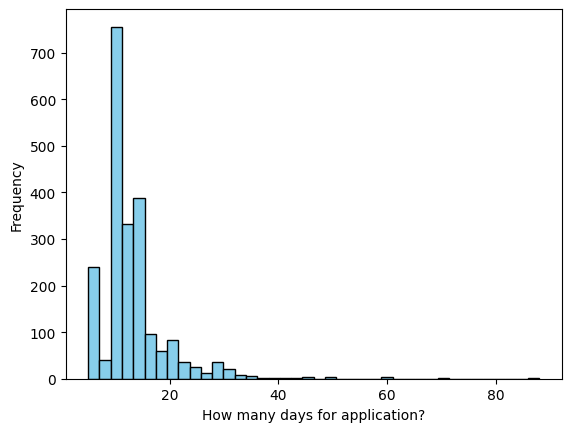

In [61]:
plt.hist(df_cleaned['Days_on'], bins=40, color='skyblue', edgecolor='black')
plt.xlabel('How many days for application?')
plt.ylabel('Frequency')
plt.show()

In [77]:
df_cleaned['Experience'].unique()

array(['Not found',
       'Doświadczenie zawodowe co najmniej 2 lata  w obszarze energetycznym lub w kontroli finansowej lub w dziale finansowym \nlub w obszarze analiz ekonomicznych',
       'Doświadczenie zawodowe   1 rok doświadczenia zawodowego w pracy biurowej – w przypadku posiadania wykształcenia średniego, albo brak – w przypadku posiadania wykształcenia wyższego',
       'Doświadczenie zawodowe co najmniej 1 rok  w administracji architektoniczno - budowlanej  lub 1 rok stażu pracy w organie nadzoru budowlanego lub 1 rok doświadczenia zawodowego w projektowaniu w zakresie architektury, budownictwa, inżynierii – potwierdzone kopiami dokumentów',
       'Doświadczenie zawodowe co najmniej  6 miesięcy w administracji publicznej lub w pracy biurowej',
       'Doświadczenie zawodowe co najmniej 2 lata  w pracy kancelaryjno-biurowej',
       'Doświadczenie zawodowe co najmniej 2 lata  w obszarze związanym z budownictwem ;',
       'Doświadczenie zawodowe   : powyżej 1 roku w adminis

In [98]:
def clean_data_experience(value):
    if "Not found" in value:
        return 0
    elif "6 miesięcy" in value:
        return 0.5
    elif "0,5 roku" in value:
        return 0.5 
    elif "3 miesi" in value:
        return 0.25
    elif "1 rok" in value:
        return 1
    elif "2,5 rok" in value:
        return 2.5
    elif " 7 mies" in value:
        return 0.583
    elif "2 lat" in value:
        return 2
    elif "3 lat" in value:
        return 3
    elif "4 lat" in value:
        return 4
    elif "5 lat" in value:
        return 5
    elif "1,5 roku" in value:
        return 1.5
    elif "6 lat" in value:
        return 6
    elif "powyżej jednego roku" in value:
        return 1
    elif "2 miesiące" in value:
        return 0.166
    elif "1 miesiąc" in value:
        return 0.083
    elif "powyżej roku" in value:
        return 1
    elif "powyżej pół roku" in value:
        return 0.5
    elif "brak" in value:
        return 0
    elif "7 lat" in value:
        return 7
    else:
        return 999

# Apply the function to the column
df_cleaned['experience_clean'] = df_cleaned['Experience'].apply(clean_data_experience)

C:\Users\mateu\AppData\Local\Temp\ipykernel_8788\179969410.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['experience_clean'] = df_cleaned['Experience'].apply(clean_data_experience)


In [101]:
df_cleaned['experience_clean'].value_counts()

experience_clean
0.000      1066
1.000       346
0.500       241
2.000       192
3.000       174
999.000      53
5.000        39
4.000        17
1.500        15
0.250         8
0.166         3
2.500         2
0.583         1
6.000         1
7.000         1
0.083         1
Name: count, dtype: int64

In [100]:
df_cleaned.head(10)

,Job Posting Number,End Result,City,Wage,Job title,Number of positions,full-time,education,Experience,If driving license,...,End date,clean_result,Wage_clean,time_clean,education_clean,driving_clean,english_clean,hybrid_clean,Days_on,experience_clean
0,131913,nabór zakończony bez wyboru kandydatki/kandydata,Koszalin,"4242,00",inspektor,1,1,Wykształcenie: średnie ...,Not found,Posiadanie prawo jazdy kat. B,...,2023-12-28,Candidate not found,1,1.0,0,1,0,0,5,0.0
1,131912,nabór zakończony wyborem kandydatki/kandydataA...,Warszawa,Not found,starszy specjalista,1,1,Wykształcenie: wyższe,Doświadczenie zawodowe co najmniej 2 lata w o...,Not found,...,2024-01-15,Candidate found,0,1.0,1,0,0,1,11,2.0
2,131910,nabór zakończony bez wyboru kandydatki/kandydata,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,...,2024-01-09,Candidate not found,0,1.0,0,0,0,1,17,0.0
3,131909,nabór zakończony wyborem kandydatki/kandydataM...,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,...,2024-01-09,Candidate found,0,1.0,0,0,0,1,17,0.0
4,131908,nabór zakończony wyborem kandydatki/kandydataE...,Warszawa,Not found,inspektor,1,1,Wykształcenie: średnie,Doświadczenie zawodowe 1 rok doświadczenia z...,Not found,...,2024-01-12,Candidate found,0,1.0,0,0,0,0,15,1.0
5,131907,nabór zakończony wyborem kandydatki/kandydataK...,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,...,2024-01-09,Candidate found,0,1.0,0,0,0,1,17,0.0
6,131906,nabór zakończony wyborem kandydatki/kandydataJ...,Kraków,Not found,inspektor wojewódzki,2,1,Wykształcenie: wyższe ...,Doświadczenie zawodowe co najmniej 1 rok w ad...,Not found,...,2024-01-02,Candidate found,0,1.0,1,0,0,0,10,1.0
7,131905,nabór zakończony bez wyboru kandydatki/kandydata,Łódź,"4019,00",specjalista,1,1,Wykształcenie: wyższe,Doświadczenie zawodowe co najmniej 6 miesięcy...,Not found,...,2023-12-29,Candidate not found,1,1.0,1,0,0,0,6,0.5
8,131904,nabór zakończony wyborem kandydatki/kandydataA...,Wrocław,Not found,inspektor,1,1,Wykształcenie: średnie,Doświadczenie zawodowe co najmniej 2 lata w p...,Not found,...,2024-01-08,Candidate found,0,1.0,0,0,0,0,12,2.0
9,131903,nabór zakończony wyborem kandydatki/kandydataP...,Warszawa,Not found,aplikant,1,1,Wykształcenie: średnie ...,Not found,Not found,...,2024-01-09,Candidate found,0,1.0,0,0,0,1,17,0.0


In [108]:
df_cleaned.sort_values(by='End date')

,Job Posting Number,End Result,City,Wage,Job title,Number of positions,full-time,education,Experience,If driving license,...,End date,clean_result,Wage_clean,time_clean,education_clean,driving_clean,english_clean,hybrid_clean,Days_on,experience_clean
2147,129360,nabór zakończony wyborem kandydatki/kandydataD...,Bydgoszcz,"5000,80",młodszy księgowy,1,1,Wykształcenie: średnie,Not found,Not found,...,2023-11-01,Candidate found,1,1.0,0,0,0,0,5,0.0
2152,129354,nabór zakończony wyborem kandydatki/kandydataD...,Poznań,"5033,65",referent,1,1,Wykształcenie: średnie,Not found,Not found,...,2023-11-03,Candidate found,1,1.0,0,0,0,0,7,0.0
2107,129408,nabór zakończony wyborem kandydatki/kandydatad...,Warszawa,"5472,32",starszy referent,2,1,Wykształcenie: średnie,"Doświadczenie zawodowe powyżej 0,5 roku w ad...",Not found,...,2023-11-04,Candidate found,1,1.0,0,0,0,1,5,0.5
2022,129509,nabór zakończony wyborem kandydatki/kandydataM...,Gdańsk,"4950,42",referent,1,1,Wykształcenie: średnie,Not found,Not found,...,2023-11-05,Candidate found,1,1.0,0,0,0,0,5,0.0
2019,129513,nabór zakończony wyborem kandydatki/kandydataK...,Zambrów,Not found,inspektor,1,1,Wykształcenie: średnie,Not found,Not found,...,2023-11-05,Candidate found,0,1.0,0,0,0,0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,130507,nabór zakończony bez wyboru kandydatki/kandydata,Katowice,Not found,starszy inspektor zakładów górniczych,1,1,Wykształcenie: wyższe ...,Not found,Not found,...,2024-01-31,Candidate not found,0,1.0,1,0,0,0,70,0.0
136,131740,nabór zakończony bez wyboru kandydatki/kandydata,Olsztyn,"4242,00",inspektor,1,1,Wykształcenie: średnie,Not found,Not found,...,2024-02-05,Candidate not found,1,1.0,0,0,0,0,13,0.0
28,131873,nie zatrudniono kandydatki/kandydata,Kraków,"5100,00",księgowy,1,1,Wykształcenie: średnie,Not found,Not found,...,2024-02-06,Candidate found,1,1.0,0,0,0,0,12,0.0
106,131780,nabór zakończony bez wyboru kandydatki/kandydata,Puławy,Not found,inspektor nadzoru budowlanego,1,1,Wykształcenie: średnie ...,Not found,"prawo jazdy kat ""B""",...,2024-02-09,Candidate not found,0,1.0,0,1,0,0,50,0.0


In [107]:
df_cleaned.to_excel("webscr_clean.xlsx")